In [59]:
import numpy as np
import math
from scipy import integrate
d = 0.25/1000       #mm 2 m
tau = 7.35*9.81     #kg 2 kgm/s^2
L= 648/1000        #mm 2 m
A = d**2*np.pi/4
omega1 = 329.63*2*np.pi # Hz to rad/s
rho = (np.pi/L)**2*tau/(A*omega1**2)
c = (tau/(rho*A))**0.5
y_listener = 1
cSpeed = 343
zeta = 0.001

# Choose number of modes to include
modeNum = 4

# Modal Masses
m_modalArray = []
for i in range(modeNum):
    m_modalArray.append(rho*A*L/2)
    
# Modal Frequencies
wn_modalArray = []
for n in range(1,modeNum+1):
    wn_modalArray.append(c*np.pi*n/L)
    
print([wn/(2*np.pi) for wn in wn_modalArray])

# Modal Stiffnesses
k_modalArray = [m_m*w_m**2 for m_m,w_m in zip(m_modalArray,wn_modalArray)]

# Modal Damping
R_modalArray = [2*zeta*w_m*m_m for m_m,w_m in zip(m_modalArray,wn_modalArray)]

# Mode Shapes
Y = lambda n,x: np.sin(n*math.pi*x/L)

p0_array = [0]*modeNum
q0_array = [0]*modeNum
x0 = p0_array + q0_array

[329.63, 659.26, 988.8899999999999, 1318.52]


In [60]:
# EOM and Simulation Setup
tspan = [0,.5]

# 10 times the frequncy we're expecting at least
f_max = wn_modalArray[-1]/(2*np.pi)*10*5

ntPoints = (tspan[1]-tspan[0])*f_max
ntPoints = math.ceil(ntPoints)
t = np.linspace(tspan[0],tspan[1],ntPoints)

def eom(t,x):
    p = x[0:modeNum]
    q = x[modeNum:2*(modeNum)]
    dp = []
    dq = []
    
    F=0.0
    t_impulse = 1/f_max
    # Impulse should happen 'intantanously', or, faster than the largest frequency
    tstart = 0
    if t>tstart and t<tstart+1/f_max:
        F=f_max
    
    for i in range(modeNum):
        dp.append(-k_modalArray[i]*q[i] -R_modalArray[i]*p[i]/m_modalArray[i] + Y(i+1,L*0.7)*F)
        dq.append(p[i]/m_modalArray[i])
        
    dx = dp + dq
    return dx

sol = integrate.solve_ivp(eom,tspan,x0,t_eval = t,max_step = 1/f_max)

In [61]:
# Find the accelarations at a location
nPoints = 20
locations = np.linspace(0,L,nPoints+2)[1:-1]

# Need the derivatives
# Reassemble the sol.y output for parsing through EOM in a for loop
yParsed = list(zip(*sol.y))

dx = []
for i in range(len(sol.t)):
    temp = eom(sol.t[i],yParsed[i])
    dx.append(temp[0:modeNum])
    
dtfun = lambda x: (y_listener**2 + x**2)**0.5/cSpeed
dtArray = [dtfun(xpos) for xpos in locations]

npadding = [math.floor(dt*f_max) for dt in dtArray]
print(npadding)

ddwArray = []
for (xpoint,pad) in zip(locations,npadding):
    ddw_point = []
    for i in range(len(sol.t)):
        a = [dx[i][j]/m_modalArray[j]*Y(j+1,xpoint) for j in range(modeNum)]
        ddw_point.append(sum(a))
    ddw_sound = [0]*pad + ddw_point[pad:]
    ddwArray.append(ddw_sound)

sound = list(map(sum, zip(*ddwArray)))

from IPython import display
display.Audio([entry/nPoints for entry in sound],rate=f_max)

[192, 192, 193, 193, 194, 195, 196, 197, 199, 201, 202, 204, 207, 209, 211, 214, 217, 219, 222, 225]


In [63]:
display.Audio([entry/nPoints for entry in ddwArray[-1]],rate=f_max)

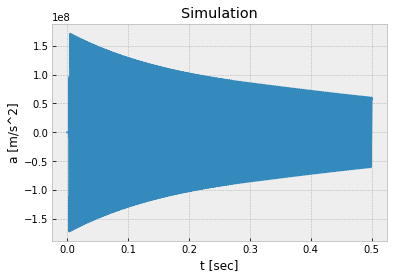

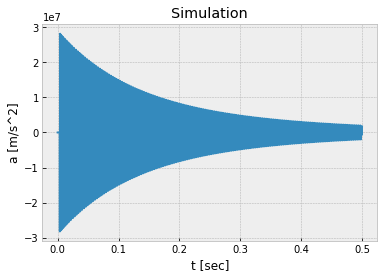

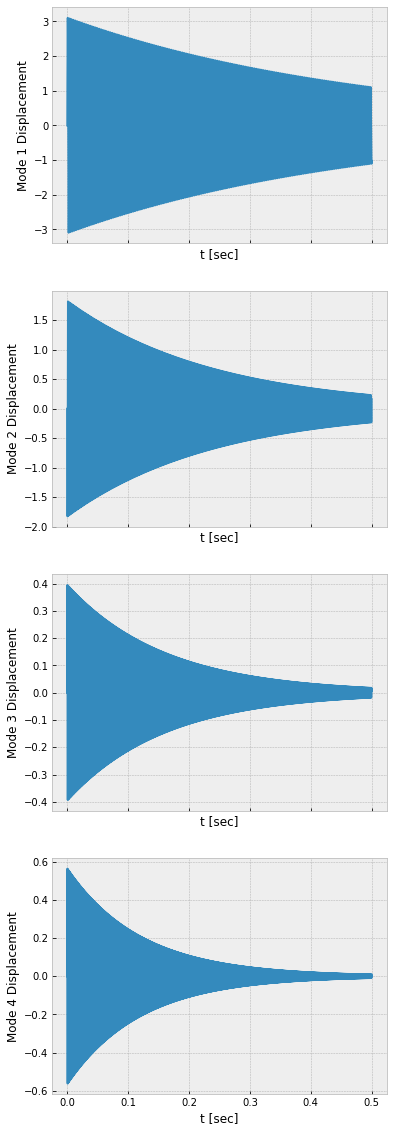

In [62]:
import matplotlib.pyplot as plt
plt.style.use('bmh')

f1 = plt.figure('Figure 1')
plt.plot(sol.t,sound)
plt.xlabel('t [sec]')
plt.ylabel('a [m/s^2]')
plt.title('Simulation')

f2 = plt.figure('Figure 2')
plt.plot(sol.t,ddwArray[-1])
plt.xlabel('t [sec]')
plt.ylabel('a [m/s^2]')
plt.title('Simulation')

f3,ax = plt.subplots(modeNum,1,sharex=True,figsize=(6,5*modeNum))
for i in range(modeNum):
    ax[i].plot(sol.t,sol.y[i+modeNum])
    ax[i].set_xlabel('t [sec]')
    ax[i].set_ylabel('Mode {} Displacement'.format(i+1))